# Tweets Sentiment & Bitcoin Price 

### Tian Zhou



### Description:
This study examines whether shifts in Twitter sentiment about Bitcoin are followed by changes in Bitcoin price returns. The hypothesis assumes a positive relationship: when sentiment becomes more optimistic, Bitcoin returns should rise shortly afterward. To capture this effect at different time scales, sentiment is measured both daily and in 5-minute intervals, and each is aligned with the corresponding next-period Bitcoin return. By comparing these two horizons, the analysis evaluates whether sentiment functions as a useful predictor of price movements over slower, day-level cycles as well as within fast, high-frequency market conditions.

# 1. Tweets Sentiment - Next Day


## Sentiment DataSet:

### Cleaning：

In [38]:
import pandas as pd

In [39]:
sent = pd.read_csv("../data/tweets_2018_2019.csv",engine="python",on_bad_lines="skip")
display(sent.head())

,timestamp,text,text_en,sentiment_score,sentiment_label
0,2018-01-01T00:00:01.000000,"Bitcoin - BTC\nPrice: $13,941.10\nChange in 1h...","Bitcoin - BTC Price: $13,941.10 Change in 1h: ...",0.00152587890625,neu
1,2018-01-01T00:00:01.000000,2018年01月01日 10:00\n[DOGE建]\n1XP=0.1561554円\n24...,01 January 2018 10:00 [DOGE] 1XP=0.1561554,0.035400390625,neu
2,2018-01-01T00:00:02.000000,"01/01 10:00現在\n\n#Bitcoin : 1,662,700円↓\n#NEM ...","01/01 10:00 #Bitcoin: 1,662,700 ↓ #NEM #XEM: 1...",0.01470947265625,neu
3,2018-01-01T00:00:03.000000,Cotizaciones al 31/12/2017 10:00 PM\nBitcoin (...,Contributions to 31/12/2017 10:00 PM Bitcoin (...,-0.0361328125,neu
4,2018-01-01T00:00:03.000000,"Cotización del Bitcoin Cash: 2,046 10.€ | -0.7...","Bitcoin Cash Rating: 2,046 10.€ -0.75% Kraken ...",0.008819580078125,neu


In [40]:
sent = sent[["timestamp", "sentiment_score"]]

sent["timestamp"] = pd.to_datetime(sent["timestamp"], errors="coerce")
sent["sentiment_score"] = pd.to_numeric(sent["sentiment_score"], errors="coerce")
sent = sent.dropna(subset=["timestamp", "sentiment_score"])
sent = sent.set_index("timestamp")

sent_daily = sent["sentiment_score"].resample("D").mean().to_frame(name="sentiment")

display(sent_daily.head())
print(sent_daily.shape)


,sentiment
timestamp,
2018-01-01,0.092741
2018-01-02,0.104680
2018-01-03,0.111727
2018-01-04,0.105181
2018-01-05,0.110334


(365, 1)


In [36]:
analyzer = SentimentIntensityAnalyzer()

crypto_slang_2018_2019 = {
    "moon": 3.0,
    "mooning": 3.0,
    "pump": 2.8,
    "pumping": 2.8,
    "bull": 2.3,
    "bullish": 3.0,
    "bullrun": 3.0,
    "breakout": 2.0,
    "ath": 2.4,
    "green_candle": 2.2,
    "hodl": 2.0,
    "hodling": 2.0,
    "lambo": 2.8,
    "buy_the_dip": 2.0,

    "crash": -3.8,
    "dump": -3.2,
    "dumping": -3.2,
    "rekt": -3.5,
    "liquidated": -3.5,
    "bearish": -3.0,
    "selloff": -3.0,
    "bloodbath": -3.5,
    "panic": -2.5,
    "fud": -2.5,
    "scam": -3.5,
    "exit_scam": -3.5,
    "bagholder": -2.2,
    "deadcat": -3.0,
    "capitulation": -3.0
}

#update
analyzer.lexicon.update(crypto_slang_2018_2019)


NameError: name 'SentimentIntensityAnalyzer' is not defined

In [37]:
def compute_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

tweets["sentiment"] = tweets["clean_text"].apply(compute_sentiment)

print("Sample sentiment scores:")
display(tweets[["clean_text", "sentiment"]].head())


KeyError: 'clean_text'

# 2. Bitcoin Price - Next Day

## 2.1 Preprocess

In [41]:
import pandas as pd

btc_path = "../data/btc_2018_2019.csv"
btc = pd.read_csv(btc_path)

#parse timestamp correctly
btc["timestamp"] = pd.to_datetime(btc["timestamp"], errors="coerce")

#remove invalid timestamps
btc = btc[btc["timestamp"].notna()]

btc["date"] = btc["timestamp"].dt.date

#compute daily closing price
daily_price = (
    btc.groupby("date")["close"]
       .last()
       .reset_index()
)

daily_price["return"] = daily_price["close"].pct_change()

display(daily_price.head())


,date,close,return
0,2018-01-01,13189.36,NaN
1,2018-01-02,14596.11,0.106658
2,2018-01-03,14834.30,0.016319
3,2018-01-04,14780.40,-0.003633
4,2018-01-05,16367.42,0.107373


## 2.2 Merge 

In [46]:
sent = sent_daily.reset_index()

sent = sent.rename(columns={"timestamp": "date","sentiment": "daily_sentiment"})

sent["date"] = pd.to_datetime(sent["date"]).dt.date
daily_price["date"] = pd.to_datetime(daily_price["date"]).dt.date

merged = pd.merge(sent, daily_price, on="date", how="inner")

merged["sentiment_lag1"] = merged["daily_sentiment"].shift(1)
merged = merged.dropna(subset=["sentiment_lag1", "return"])

display(merged.head())


,date,daily_sentiment,close,return,sentiment_lag1
1,2018-01-02,0.104680,14596.11,0.106658,0.092741
2,2018-01-03,0.111727,14834.30,0.016319,0.104680
3,2018-01-04,0.105181,14780.40,-0.003633,0.111727
4,2018-01-05,0.110334,16367.42,0.107373,0.105181
5,2018-01-06,0.116845,16772.83,0.024769,0.110334


### Scatter Plot: sentiment_lag1 vs return

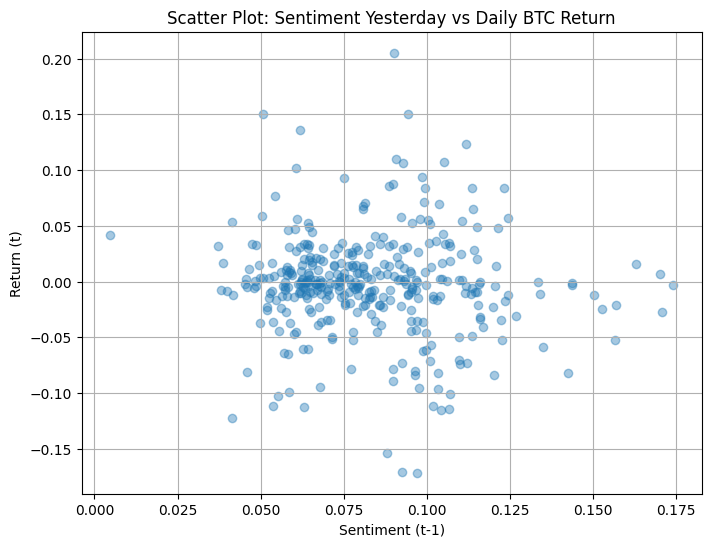

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(merged["sentiment_lag1"], merged["return"], alpha=0.4)
plt.xlabel("Sentiment (t-1)")
plt.ylabel("Return (t)")
plt.title("Scatter Plot: Sentiment Yesterday vs Daily BTC Return")
plt.grid(True)
plt.show()


### Time Series Plot

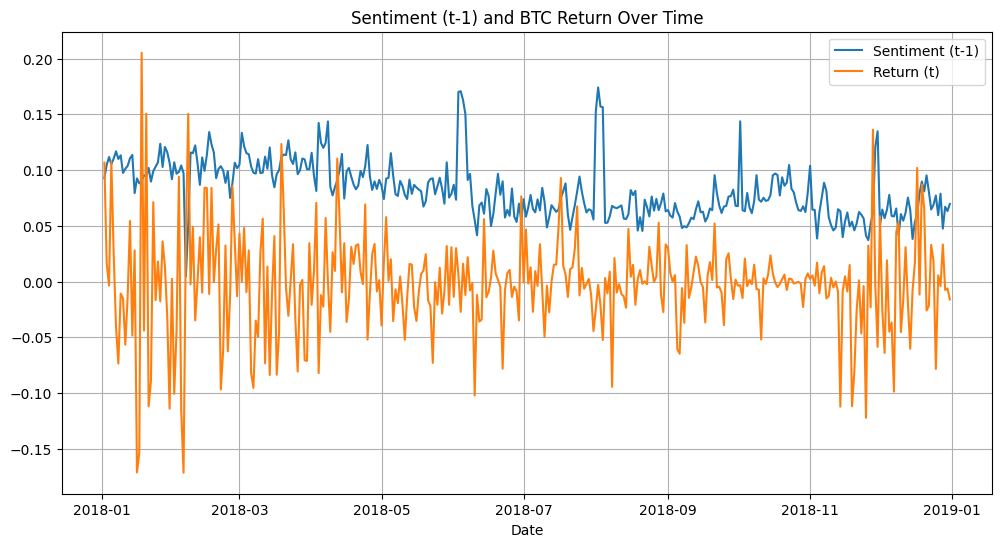

In [48]:
plt.figure(figsize=(12,6))
plt.plot(merged["date"], merged["sentiment_lag1"], label="Sentiment (t-1)")
plt.plot(merged["date"], merged["return"], label="Return (t)")
plt.legend()
plt.title("Sentiment (t-1) and BTC Return Over Time")
plt.xlabel("Date")
plt.grid(True)
plt.show()


## 2.3 Correlation


In [49]:
corr_value = merged["sentiment_lag1"].corr(merged["return"])
print("Pearson Correlation between sentiment_lag1 and return:", corr_value)


Pearson Correlation between sentiment_lag1 and return: -0.06198073863650449


### Rolling Correlation

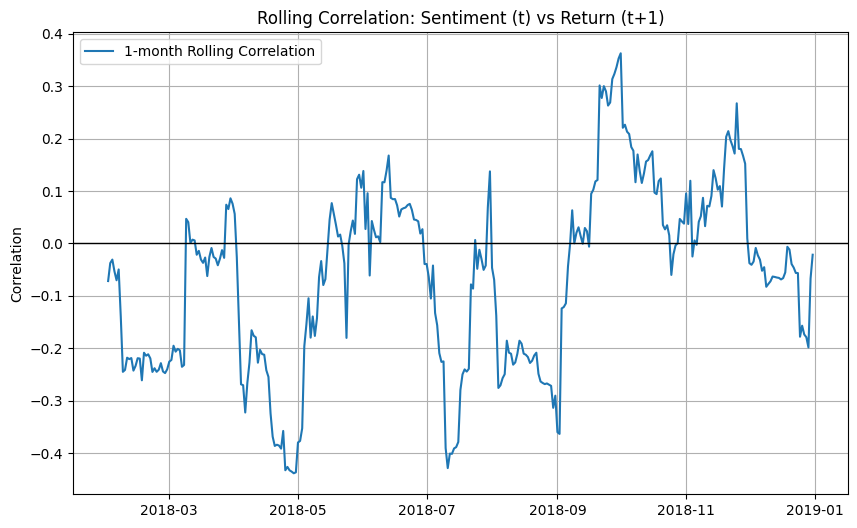

In [73]:
merged["rolling_corr"] = merged["sentiment_lag1"].rolling(30).corr(merged["return"])

plt.figure(figsize=(10,6))
plt.plot(merged["date"], merged["rolling_corr"], label="1-month Rolling Correlation")
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling Correlation: Sentiment (t) vs Return (t+1)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


## 2.4 Regression

In [74]:
!pip install statsmodels


In [75]:
import statsmodels.api as sm

# Use sentiment_lag1 to predict next-day return
df = merged.dropna(subset=["sentiment_lag1", "return"])

X = df[["sentiment_lag1"]]           # predictor
y = df["return"]                     # target variable

X = sm.add_constant(X)               # adds intercept
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.396
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.238
Time:                        00:05:14   Log-Likelihood:                 606.81
No. Observations:                 364   AIC:                            -1210.
Df Residuals:                     362   BIC:                            -1202.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0070      0.008      0.

### Scatter + Regression Line

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt


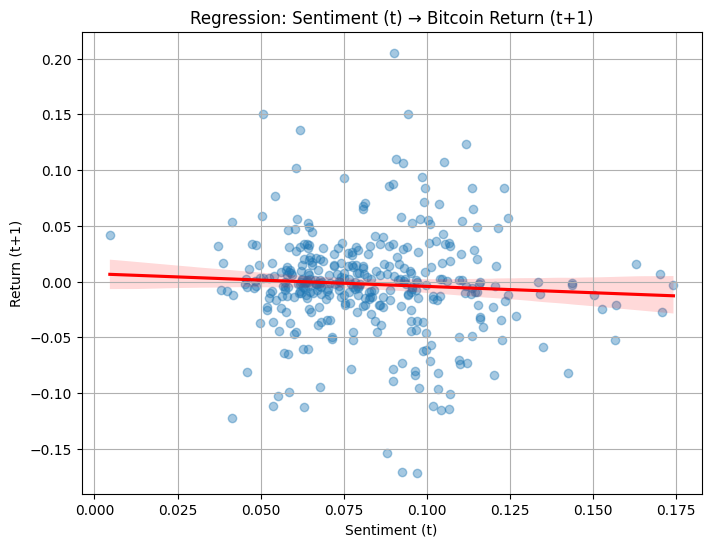

In [77]:
plt.figure(figsize=(8,6))
sns.regplot(x=df["sentiment_lag1"], y=df["return"], scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("Sentiment (t)")
plt.ylabel("Return (t+1)")
plt.title("Regression: Sentiment (t) → Bitcoin Return (t+1)")
plt.grid(True)
plt.show()


# 3. Tweets Sentiment - 5 minutes

In [78]:
sent = pd.read_csv("../data/tweets_2018_2019.csv", engine="python", on_bad_lines="skip")
sent = sent[["timestamp", "sentiment_score"]]

sent["timestamp"] = pd.to_datetime(sent["timestamp"], errors="coerce")
sent["sentiment_score"] = pd.to_numeric(sent["sentiment_score"], errors="coerce")

sent = sent.dropna(subset=["timestamp", "sentiment_score"])
sent = sent.set_index("timestamp")

# 5 minute sentiment
sent_5min = sent["sentiment_score"].resample("5min").mean()
sent_5min = sent_5min.to_frame(name="sentiment")

display(sent_5min.head())

# Save
sent_5min.to_csv("../data/sentiment_5min.csv")


,sentiment
timestamp,
2018-01-01 00:00:00,0.113407
2018-01-01 00:05:00,0.074455
2018-01-01 00:10:00,NaN
2018-01-01 00:15:00,0.143984
2018-01-01 00:20:00,0.046783


# 4. Bitcoin Price - 5 minutes

## 4.1 Preprocess

In [79]:
btc = pd.read_csv("../data/btc_2018_2019.csv")

btc["timestamp"] = pd.to_datetime(btc["timestamp"], errors="coerce")
btc = btc.dropna(subset=["timestamp"])
btc = btc.set_index("timestamp")

btc_5min = btc.resample("5min").last()
btc_5min["return"] = btc_5min["close"].pct_change()

btc_5min = btc_5min[["close", "return"]]

display(btc_5min.head())


,close,return
timestamp,,
2018-01-01 00:00:00,13880.45,NaN
2018-01-01 00:05:00,13978.73,0.007080
2018-01-01 00:10:00,13999.14,0.001460
2018-01-01 00:15:00,14002.69,0.000254
2018-01-01 00:20:00,13979.95,-0.001624


## 4.2 Merge

In [80]:
sent_5min_df = sent_5min.reset_index().rename(columns={"timestamp": "datetime"})
btc_5min_df = btc_5min.reset_index().rename(columns={"timestamp": "datetime"})

merged_5min = pd.merge(sent_5min_df, btc_5min_df, on="datetime", how="inner")

merged_5min["sentiment_lag1"] = merged_5min["sentiment"].shift(1)

merged_5min = merged_5min.dropna(subset=["sentiment_lag1", "return"])

display(merged_5min.head())
print(merged_5min.shape)


,datetime,sentiment,close,return,sentiment_lag1
1,2018-01-01 00:05:00,0.074455,13978.73,0.007080,0.113407
2,2018-01-01 00:10:00,NaN,13999.14,0.001460,0.074455
4,2018-01-01 00:20:00,0.046783,13979.95,-0.001624,0.143984
5,2018-01-01 00:25:00,0.148649,13886.89,-0.006657,0.046783
6,2018-01-01 00:30:00,0.047063,13945.07,0.004190,0.148649


(82111, 5)


### Scatter Plot: sentiment_lag1 vs return

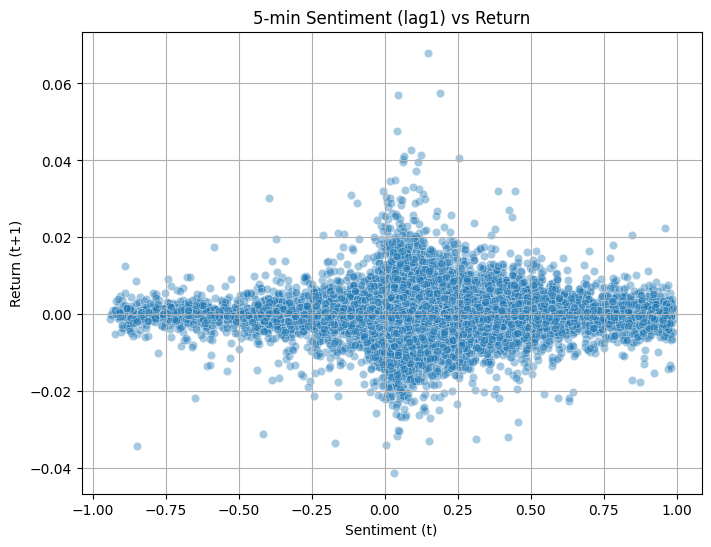

In [95]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    x=merged_5min["sentiment_lag1"],
    y=merged_5min["return"],
    alpha=0.4
)


plt.xlabel("Sentiment (t)")
plt.ylabel("Return (t+1)")
plt.title("5-min Sentiment (lag1) vs Return")
plt.grid(True)
plt.show()


### Time Series Plot

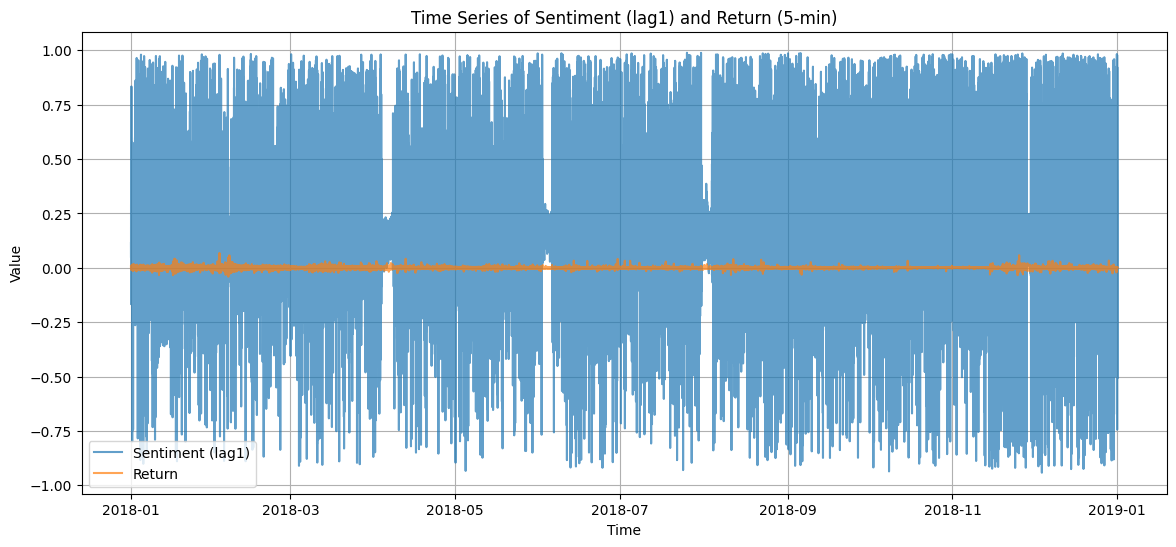

In [96]:
plt.figure(figsize=(14,6))

plt.plot(merged_5min["datetime"], merged_5min["sentiment_lag1"], label="Sentiment (lag1)", alpha=0.7)
plt.plot(merged_5min["datetime"], merged_5min["return"], label="Return", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series of Sentiment (lag1) and Return (5-min)")
plt.legend()
plt.grid(True)
plt.show()


## 4.3 Correlation

In [97]:
corr = merged_5min["sentiment_lag1"].corr(merged_5min["return"])
print("Correlation (sentiment → next 5-min return):", corr)


Correlation (sentiment → next 5-min return): 0.0014094939988615652


### Rolling Correlation

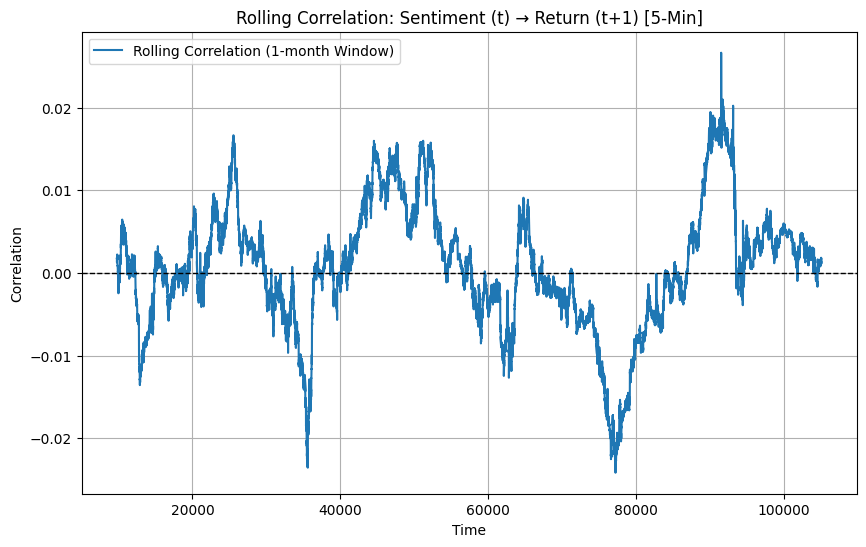

In [98]:
window_size = 8640  # 1 month of 5-min intervals

merged_5min["rolling_corr"] = (
    merged_5min["sentiment_lag1"]
    .rolling(window_size)
    .corr(merged_5min["return"])
)

plt.figure(figsize=(10,6))
plt.plot(merged_5min.index, merged_5min["rolling_corr"], label="Rolling Correlation (1-month Window)")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("Rolling Correlation: Sentiment (t) → Return (t+1) [5-Min]")
plt.grid(True)
plt.legend()
plt.show()


## 4.4 Regression

In [99]:
X = merged_5min["sentiment_lag1"]
y = merged_5min["return"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1631
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.686
Time:                        00:19:08   Log-Likelihood:             3.5876e+05
No. Observations:               82111   AIC:                        -7.175e+05
Df Residuals:                   82109   BIC:                        -7.175e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.266e-06   1.27e-05     -0.

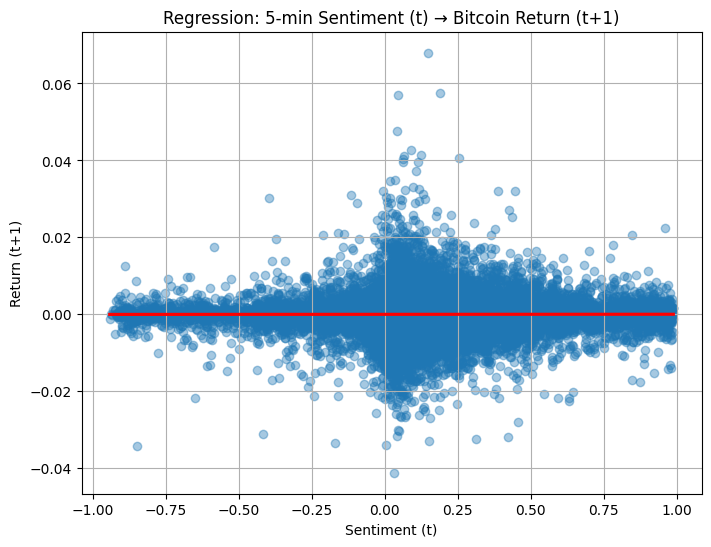

In [102]:
plt.figure(figsize=(8,6))

sns.regplot(
    x=merged_5min["sentiment_lag1"],
    y=merged_5min["return"],
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)

plt.xlabel("Sentiment (t)")
plt.ylabel("Return (t+1)")
plt.title("Regression: 5-min Sentiment (t) → Bitcoin Return (t+1)")
plt.grid(True)
plt.show()


# Comparison

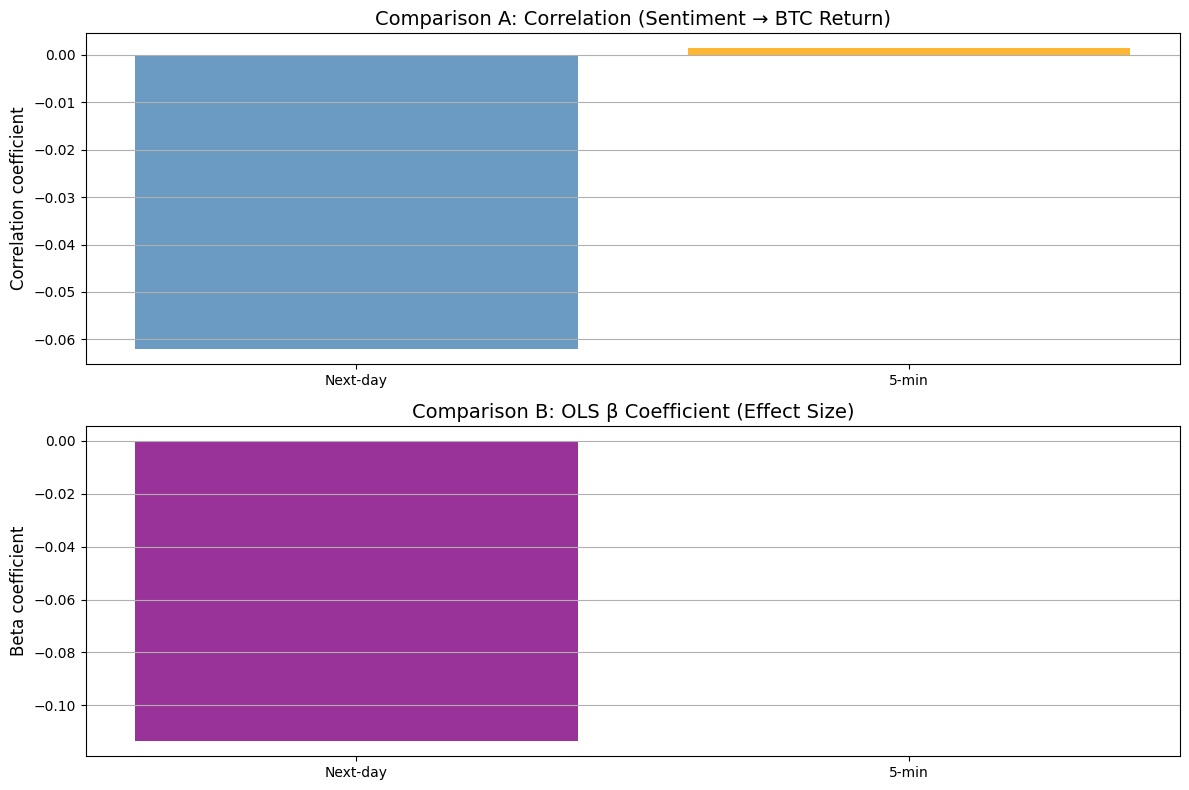

In [106]:
corr_values = {
    "Next-day": -0.06198,
    "5-min": 0.00140
}

coeff_values = {
    "Next-day": -0.1136,
    "5-min": 0.0000208
}

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.bar(corr_values.keys(), corr_values.values(), 
        color=["steelblue", "orange"], alpha=0.8)
plt.title("Comparison A: Correlation (Sentiment → BTC Return)", fontsize=14)
plt.ylabel("Correlation coefficient", fontsize=12)
plt.grid(True, axis="y")


plt.subplot(2, 1, 2)
plt.bar(coeff_values.keys(), coeff_values.values(), 
        color=["purple", "green"], alpha=0.8)
plt.title("Comparison B: OLS β Coefficient (Effect Size)", fontsize=14)
plt.ylabel("Beta coefficient", fontsize=12)
plt.grid(True, axis="y")

plt.tight_layout()
plt.show()


# Results & Discussion

Across both the daily and 5-minute horizons, the results show that Twitter sentiment has very limited predictive value for Bitcoin returns. The next-day effect is slightly negative, while the 5-minute effect is slightly positive, but both are extremely close to zero. In other words, sentiment moves and price moves do not line up in any consistent or meaningful way. These patterns suggest that public Twitter mood does not reliably lead Bitcoin price changes. Any reactions the market has to sentiment may simply be too weak, too noisy, or too immediate to translate into predictable returns. Overall, Bitcoin behaves much like an efficient market here—at least with respect to publicly observable social sentiment—where prices adjust quickly enough that simple sentiment-based signals do not offer forecasting power.